## Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
from utils.plot_util import *
import socket
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [3]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/2021-01-27-V24/*/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/2021-01-27-V24/*/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/2021-01-27-V24/*/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list

['D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM2.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\3_Phase_B-E\\20210201_3_Phase_B-E_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\3_Phase_B-E\\20210201_3_Phase_B-E_LEM2.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\4_Phase_C-F\\20210202_4_Phase_C-F_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\4_Phase_C-F\\20210202_4_Phase_C-F_LEM2.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM2.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\7_Phase_C-F\\20210218_7_Phase_C-F_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\7_Phase_C-F\\20210218_7_Phase_C-F_LEM2.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\9_Phase_B-E\\9_Phase_B-E_

In [4]:
# TODO 
file = file_list[6] # 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM1.h5'
# file = file_list[-2] # 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\9_Phase_B-E_LEM1.h5'
filename = file.split(os.sep)[-1][:-3]
pklName = DIR + '/data/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 
h51 = h5py.File(file, "r")

print(filename)
print("ATTR:")
print(h51.attrs.keys())
print("Keys:")
print(h51.keys())
print("Points:")
print(h51['t'].shape)
print("shift_opts_freqs_all:")
print(shift_opts_freqs_all.shape)


20210218_5_Phase_A-D_LEM1
ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>
Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>
Points:
(1069543,)
shift_opts_freqs_all:
(121, 1069543)


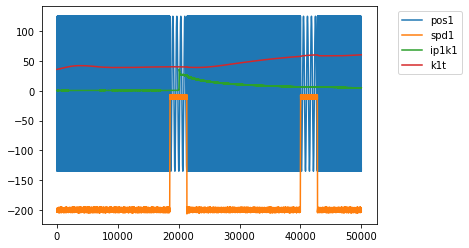

In [5]:
GT = ['pos1','spd1','ip1k1','k1t']
for gt in GT:
    plt.plot(h51[gt][:50000], label = gt)
plt.legend(bbox_to_anchor=(1.05, 1))

In [6]:
low = np.where(h51['spd1'][:]>-50)[0]
# skip the lsa in first 10000 points because some wierd patterns in speed, 
# check 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM2.h5', 
if filename in ['20210127_Phase_A-D_LEM2']:
    low = low[low>10000]
pos_low = h51['pos1'][low]
low_sep = np.where(np.diff(low)>3000)[0] # check if 3000 fit for all datasets
pos_low_sep = np.split(pos_low,low_sep+1)
Ls = np.append(low[low_sep],low[-1])
Fs = np.append(low[0],low[low_sep+1])
if filename in ["20210218_7_Phase_C-F_LEM1","20210218_7_Phase_C-F_LEM2"]:
    Ls = Ls[:-1]
    Fs = Fs[:-1]

In [8]:
N = 100 # ignore first N points
s21 = np.array(h51['S21_P1_LEM1'])
dataset = []
for j in range (121):
    index = np.arange(N,len(h51['t'])) - shift_opts_freqs_all[j,N:].round().astype(int)
    dataset.append(s21[index,j].real)
    dataset.append(s21[index,j].imag)
    
X = np.asarray(dataset).T
y = np.vstack(
    (
        np.asarray(h51['pos1'][N:]),
        np.asarray(h51['spd1'][N:]),
        np.asarray(h51['ip1k1'][N:]),
        np.asarray(h51['k1t'][N:])
    )
)
y = y.T
print("X:")
print(X.shape)
print("y:")
print(y.shape)

X:
(1069443, 242)
y:
(1069443, 4)


In [9]:
h51.close()

## Preprocessing

In [10]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

# indices2 = np.arange(X_train.shape[0])
# X_train2, X_val, y_train2, y_val, idx_train2, idx_val = train_test_split(X_train, y_train, indices2, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

print(X_train.shape)
print(X_test.shape)

(855554, 242)
(213889, 242)


In [10]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
# scaler.mean_.shape

In [11]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))

# BATCH_SIZE = 64

# train_dataset = train_dataset.batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)
# val_dataset = val_dataset.batch(BATCH_SIZE)

## Hyperparameter fine-tuning

In [34]:
def baseline_model():
  model = keras.Sequential([
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(4,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [37]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=64, verbose=0)
kfold = KFold(n_splits=3)
results = cross_val_score(estimator, X_val_scaled, y_val, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (abs(results.mean()), results.std()))

Baseline: 0.53 (0.13) MSE


## Training

### Baseline model with normalization

In [12]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [15]:
def baseline_model_norm(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(4,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [16]:
NN_norm = baseline_model_norm(normalizer)
NN_norm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 40,105
Trainable params: 39,620
Non-trainable params: 485
_________________________________________________________________


In [17]:
%%time
history = NN_norm.fit(
    X_train, y_train, batch_size = 64,
    validation_split = 0.125,
    verbose=0, epochs=100)

CPU times: user 35min 15s, sys: 2min 45s, total: 38min 1s
Wall time: 21min 25s


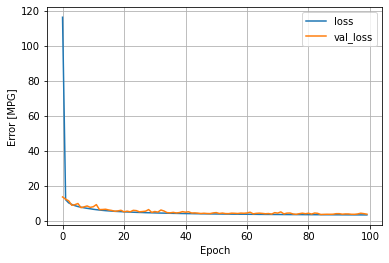

In [18]:
plot_loss(history)

In [19]:
NN_norm.save(DIR + "/models/NN_norm_combi")

INFO:tensorflow:Assets written to: /home/xin/projects/trelleborg/models/NN_norm_combi/assets


In [13]:
NN_norm = tf.keras.models.load_model(DIR + "/models/NN_norm_combi")

In [14]:
# evaluation on both training and test sets

# X_ = scaler.fit_transform(X)
y_ = NN_norm.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [23]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,4.284039,4.703059
1,spd1,6.496865,6.902727
2,ip1k1,0.330390,0.334493
3,k1t,2.719374,2.881052


In [29]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
y_train_lsa_ = y_[idx_com_train]
y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(y[idx_com_train] - y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(y[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,1.154964,1.220226
1,spd1,17.794670,17.937450
2,ip1k1,1.029761,1.014558
3,k1t,1.879746,1.941555


In [30]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  3.457667044712964
MSE of the prediction on test set:  3.7053327479517453


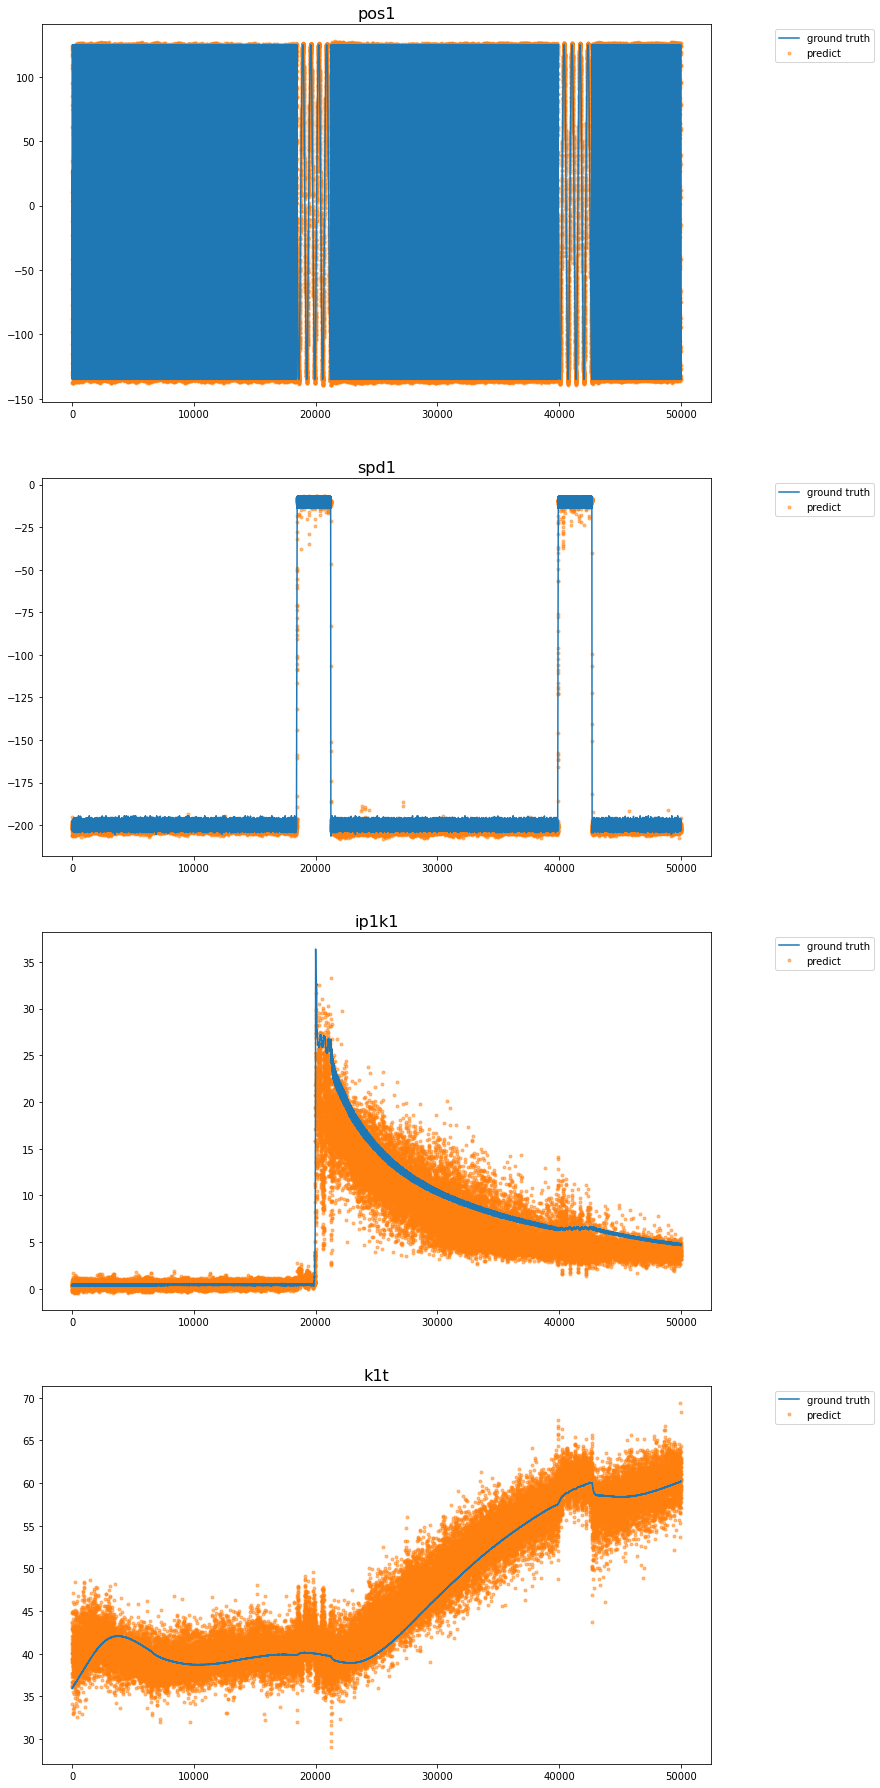

In [15]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
%matplotlib inline
plot_gt_pre_overlap_mul(y,y_,GT)

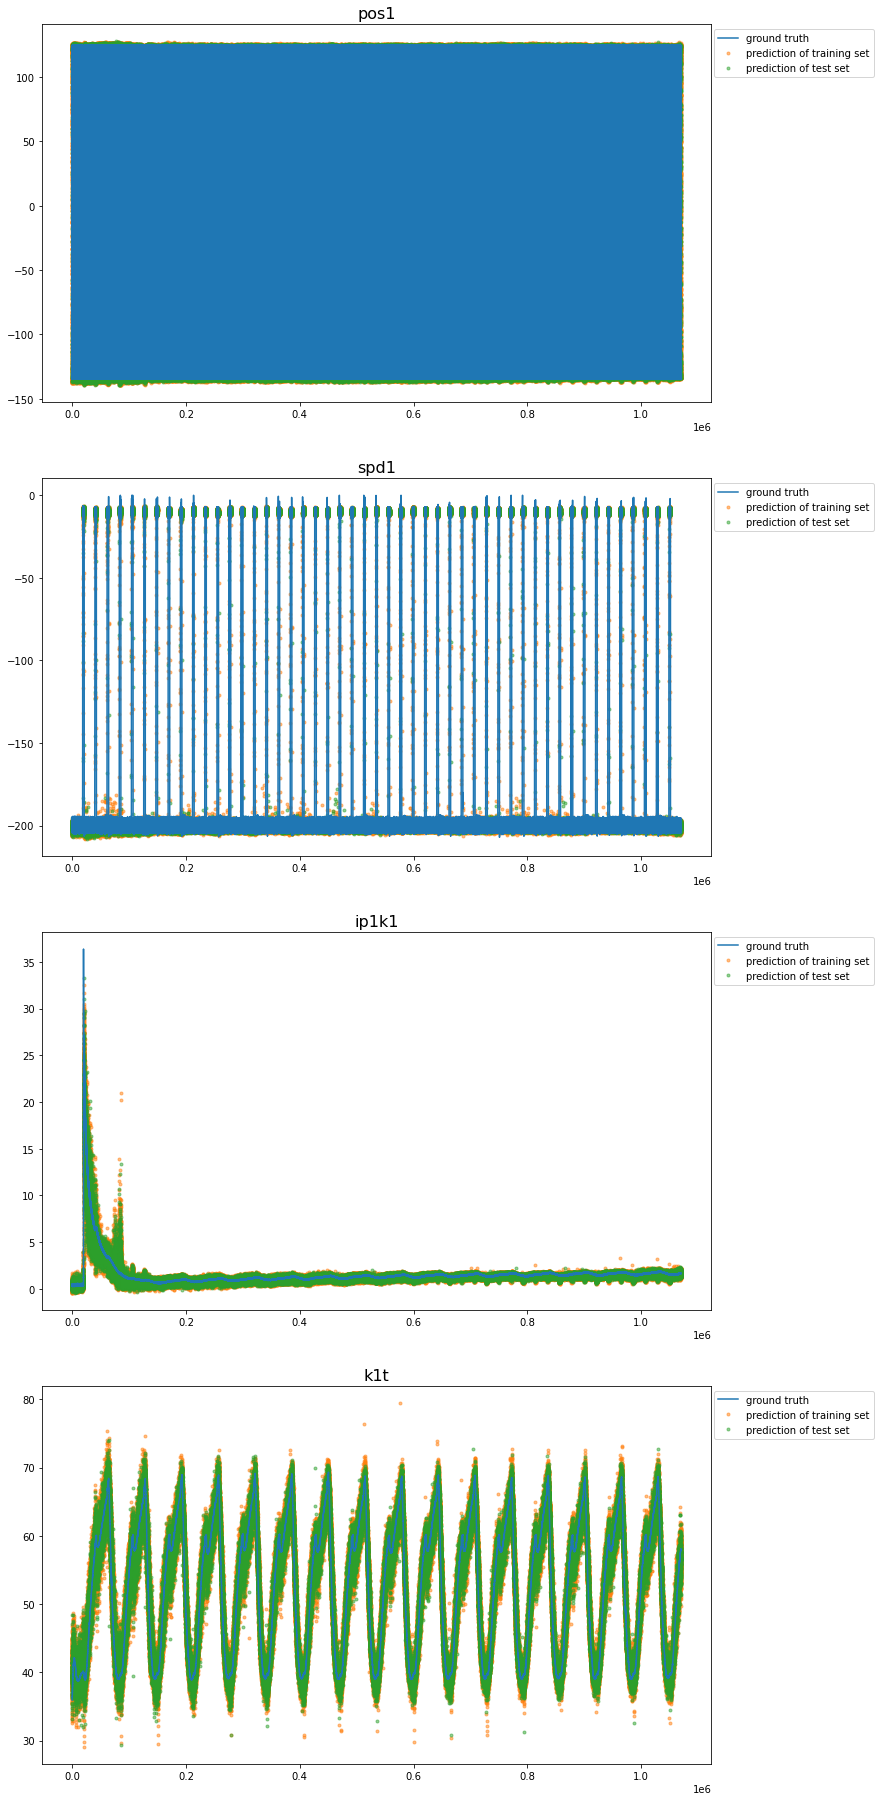

In [16]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

### Model of Previous Project

In [12]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [22]:
def model_pp(norm):
  model = keras.Sequential([
      norm,
      # layers.Dense(242, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(100, input_dim=242, kernel_initializer='normal',activation='relu'),
      layers.Dense(4,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [23]:
NN_pp= model_pp(normalizer)
NN_pp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               24300     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 24,886
Trainable params: 24,401
Non-trainable params: 485
_________________________________________________________________


In [24]:
%%time
history = NN_pp.fit(
    X_train, y_train, batch_size = 64,
    validation_split = 0.125,
    verbose=0, epochs=100)

Wall time: 40min 20s


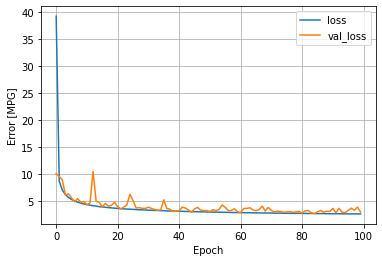

In [25]:
plot_loss(history)

In [26]:
# evaluation on both training and test sets
from sklearn.metrics import mean_squared_error
# X_ = scaler.fit_transform(X)
y_ = NN_pp.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  2.7774016372074004
MSE of the prediction on test set:  2.9706899944212446


No handles with labels found to put in legend.
C:\LINHC\Software\Python\L737\scribble\xin\trelleborg\utils\plot_util.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


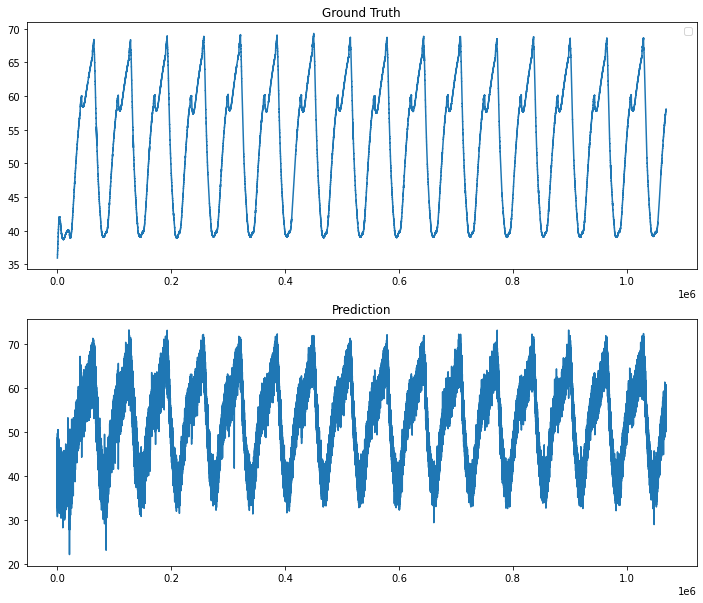

In [27]:
# predictioin vs ground truth
%matplotlib inline
plot_gt_pre(y,y_)

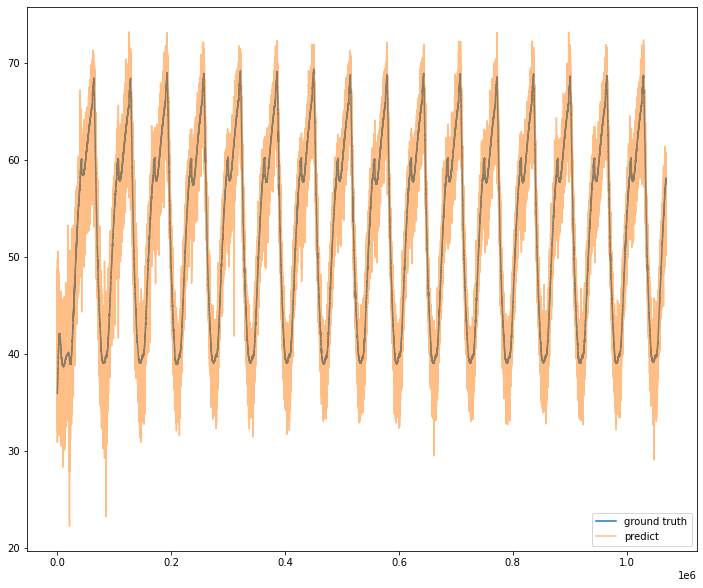

In [28]:
# predictioin vs ground truth in one plot
%matplotlib inline
plot_gt_pre_overlap(y,y_)

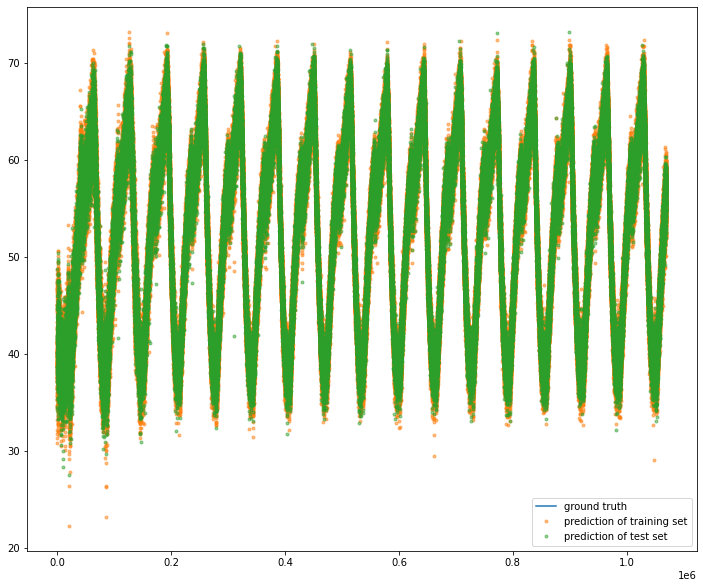

In [29]:
# (predictioin for X_test and X_train separately) vs (ground truth)  in one plot
%matplotlib inline
plot_gt_pre_sep(y,idx_train_sort,y_train_,idx_test_sort,y_test_)

In [30]:
NN_pp.save(DIR + "/models/NN_pp_temp")

INFO:tensorflow:Assets written to: ./models/NN_pp_temp\assets


In [ ]:
NN_pp = tf.keras.models.load_model(DIR + "/models/NN_pp")

#### Training with another dataset

gives back similar results. Code and output are omitted for the sake of simplicity